In [2]:
#######################################################
#######################################################
############    COPYRIGHT - DATA SOCIETY   ############
#######################################################
#######################################################

## ANOMALY DETECTION PART 1 ##

## NOTE: To run individual pieces of code, select the line of code and
##       press ctrl + enter for PCs or command + enter for Macs




In [3]:
# %pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 5.3 MB/s eta 0:00:00:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
#=================================================-
#### Slide 27: Loading packages  ####

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.tree import DecisionTreeClassifier




In [2]:
#=================================================-
#### Slide 28: Directory settings  ####

# Set 'main_dir' to location of the project folder
# from pathlib import Path 
# home_dir = Path(".").resolve()
# main_dir = home_dir.parent.parent
# print(main_dir)
# data_dir = str(main_dir) + "/data"
# print(data_dir)




/workspaces
/workspaces/data


In [10]:
#=================================================-
#### Slide 29: Load the dataset  ####
#paysim = pd.read_csv(str(data_dir)+"/paysim_transactions.csv")
paysim = pd.read_csv("/workspaces/AnomalyDetection/Anomaly+Detection+data/data/paysim_transactions.csv")
paysim.head()





,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,308,CASH_OUT,94270.99,C473084216,0.0,0.0,C1130422007,392411.08,486682.07,0,0
1,215,TRANSFER,1068883.00,C116497934,227.3,0.0,C321541184,4096905.34,5165788.35,0,0
2,326,TRANSFER,2485281.21,C2089305953,54940.0,0.0,C1473680645,177829.59,2663110.80,0,0
3,371,PAYMENT,2243.36,C1200351076,0.0,0.0,M1583169191,0.00,0.00,0,0
4,283,PAYMENT,5845.82,C1501258365,0.0,0.0,M1431167213,0.00,0.00,0,0


In [9]:
paysim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20220 entries, 0 to 20219
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            20220 non-null  int64  
 1   type            20220 non-null  object 
 2   amount          20220 non-null  float64
 3   nameOrig        20220 non-null  object 
 4   oldbalanceOrg   20220 non-null  float64
 5   newbalanceOrig  20220 non-null  float64
 6   nameDest        20220 non-null  object 
 7   oldbalanceDest  20220 non-null  float64
 8   newbalanceDest  20220 non-null  float64
 9   isFraud         20220 non-null  int64  
 10  isFlaggedFraud  20220 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 1.7+ MB


In [11]:
Path.cwd()

PosixPath('/workspaces/AnomalyDetection/Part 1-2')

In [12]:
#=================================================-
#### Slide 30: Understand the dataset  ####

paysim.columns




Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

isFraud
0    0.98912
1    0.01088
Name: count, dtype: float64


<Axes: ylabel='isFraud'>

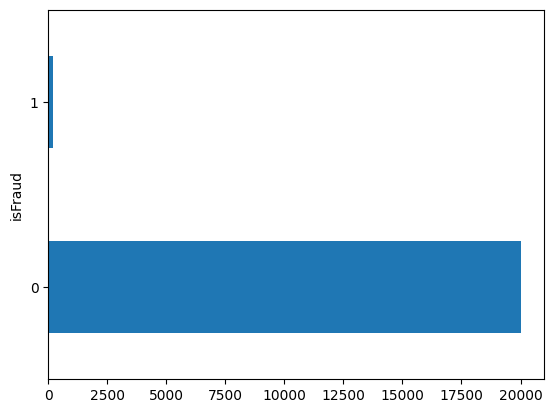

In [16]:
#=================================================-
#### Slide 31: Target of the dataset  ####

paysim['isFraud'].value_counts(normalize=True)*100

print(paysim['isFraud'].value_counts() / len(paysim))
paysim['isFraud'].value_counts().plot(kind = 'barh')




In [20]:
#=================================================-
#### Slide 32: EDA of the dataset  ####

paysim.isnull().sum()





step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

<Axes: ylabel='type'>

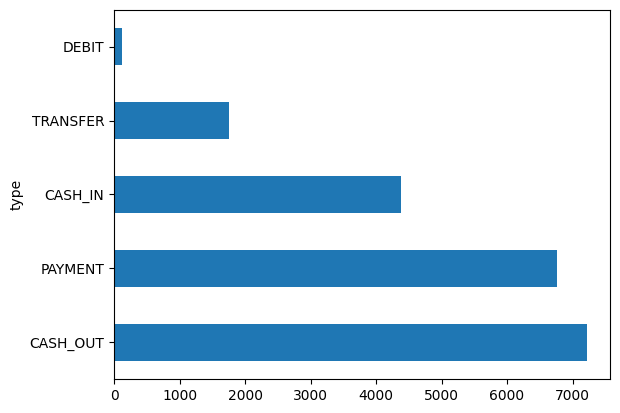

In [19]:
paysim['type'].value_counts().plot(kind = 'barh')

In [21]:
#=================================================-
#### Slide 34: Subset the data  ####

# Subset variables from fraud dataset
paysim_dbscan = paysim.drop(['step', 'type','nameOrig', 'nameDest', 'isFlaggedFraud','isFraud'], axis = 1)
print(paysim_dbscan.head())




       amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest
0    94270.99            0.0             0.0       392411.08       486682.07
1  1068883.00          227.3             0.0      4096905.34      5165788.35
2  2485281.21        54940.0             0.0       177829.59      2663110.80
3     2243.36            0.0             0.0            0.00            0.00
4     5845.82            0.0             0.0            0.00            0.00


In [22]:
#=================================================-
#### Slide 35: Data cleaning: NAs  ####

print(paysim_dbscan.isnull().sum())




amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
dtype: int64


In [23]:
?StandardScaler

Init signature: StandardScaler(*, copy=True, with_mean=True, with_std=True)
Docstring:     
Standardize features by removing the mean and scaling to unit variance.

The standard score of a sample `x` is calculated as:

    z = (x - u) / s

where `u` is the mean of the training samples or zero if `with_mean=False`,
and `s` is the standard deviation of the training samples or one if
`with_std=False`.

Centering and scaling happen independently on each feature by computing
the relevant statistics on the samples in the training set. Mean and
standard deviation are then stored to be used on later data using
:meth:`transform`.

Standardization of a dataset is a common requirement for many
machine learning estimators: they might behave badly if the
individual features do not more or less look like standard normally
distributed data (e.g. Gaussian with 0 mean and unit variance).

For instance many elements used in the objective function of
a learning algorithm (such as the RBF kernel of Suppor

In [24]:
#=================================================-
#### Slide 36: StandardScalar  ####

# Instantiate MinMaxScaler.
scaler = StandardScaler()

# Scale the dataframe.
paysim_dbscan_scaled = scaler.fit_transform(paysim_dbscan)
# Convert back to dataframe, making sure to name the columns again.
paysim_dbscan_scaled = pd.DataFrame(paysim_dbscan_scaled, columns = paysim_dbscan.columns)
print(paysim_dbscan_scaled.head())




     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest
0 -0.158339      -0.291955       -0.291554       -0.210158       -0.205427
1  1.360976      -0.291878       -0.291554        0.924753        1.108908
2  3.568988      -0.273385       -0.291554       -0.275897        0.405920
3 -0.301800      -0.291955       -0.291554       -0.330377       -0.342133
4 -0.296184      -0.291955       -0.291554       -0.330377       -0.342133


In [25]:
#=================================================-
#### Slide 38: DBSCAN: model   ####

# Let's run DBSCAN.
dbscan = DBSCAN(eps=0.2, min_samples = 5)
clusters = dbscan.fit_predict(paysim_dbscan_scaled)

# Check the number of clusters
unique, counts = np.unique(clusters, return_counts=True)
print(np.asarray((unique, counts)).T)




[[   -1   901]
 [    0 19139]
 [    1     7]
 [    2     7]
 [    3     9]
 [    4    21]
 [    5    21]
 [    6     5]
 [    7     7]
 [    8    11]
 [    9     5]
 [   10     6]
 [   11    15]
 [   12    10]
 [   13     5]
 [   14     5]
 [   15    15]
 [   16     5]
 [   17     9]
 [   18     7]
 [   19     5]
 [   20     5]]


In [ ]:
#=================================================-
#### Slide 39: Exercise 1  ####






In [26]:
#=================================================-
#### Slide 44: Optimal Eps determination  ####

nn_model = NearestNeighbors(n_neighbors=10)
nbrs = nn_model.fit(paysim_dbscan_scaled)
distances, indices = nbrs.kneighbors(paysim_dbscan_scaled)
distances = np.mean(distances,axis=1)
distances = np.sort(distances, axis=0)




In [27]:
distances

array([7.56842217e-06, 7.56842217e-06, 7.64013122e-06, ...,
       1.27639126e+01, 2.24483652e+01, 2.50760286e+01])

In [ ]:
#=================================================-
#### Slide 47: DBSCAN: optimized model  ####

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples = 10)
optimized_clusters = dbscan.fit_predict(paysim_dbscan_scaled)

# Check the number of clusters
unique, counts = np.unique(optimized_clusters, return_counts=True)
print(np.asarray((unique, counts)).T)
paysim_dbscan['cluster'] = optimized_clusters

paysim_dbscan.loc[paysim_dbscan['cluster'] >= 0,'cluster'] = 0
paysim_dbscan.loc[paysim_dbscan['cluster'] == -1,'cluster'] = 1




In [ ]:
#=================================================-
#### Slide 48: Visualize the Anomalies  ####

fig, ax = plt.subplots()
sc = ax.scatter(paysim_dbscan['oldbalanceOrg'], paysim_dbscan['newbalanceOrig'], c = paysim_dbscan['cluster'], alpha = 0.8)
ax.legend(*sc.legend_elements())
plt.xlabel('Amount of transaction')
plt.ylabel('Origin new balance after transaction')
fig, ax = plt.subplots()
sc = ax.scatter(paysim_dbscan['oldbalanceOrg'], paysim_dbscan['newbalanceOrig'], c = paysim_dbscan['cluster'], alpha = 0.8)
ax.legend(*sc.legend_elements())
plt.xlabel('Amount of transaction')
plt.ylabel('Origin new balance after transaction')




In [ ]:
#=================================================-
#### Slide 49: Visualize the Anomalies  ####

fig, ax = plt.subplots()
sc = ax.scatter(paysim_dbscan['amount'], paysim_dbscan['newbalanceDest'], c = paysim_dbscan['cluster'], alpha = 0.8)
ax.legend(*sc.legend_elements())
plt.xlabel('Amount')
plt.ylabel('Recipient new Balance after transaction')
plt.show()
fig, ax = plt.subplots()
sc = ax.scatter(paysim_dbscan['amount'], paysim_dbscan['newbalanceDest'], c = paysim_dbscan['cluster'], alpha = 0.8)
ax.legend(*sc.legend_elements())
plt.xlabel('Amount')
plt.ylabel('Recipient new Balance after transaction')
plt.show()




In [ ]:
#=================================================-
#### Slide 52: Exercise 2  ####




#######################################################
####  CONGRATULATIONS ON COMPLETING THIS MODULE!   ####
#######################################################


In [ ]:
#######################################################
#######################################################
############    COPYRIGHT - DATA SOCIETY   ############
#######################################################
#######################################################

## ANOMALY DETECTION PART 2 ##

## NOTE: To run individual pieces of code, select the line of code and
##       press ctrl + enter for PCs or command + enter for Macs




In [ ]:
#=================================================-
#### Slide 4: Loading packages  ####

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.tree import DecisionTreeClassifier




In [ ]:
#=================================================-
#### Slide 5: Directory settings  ####

# Set 'main_dir' to location of the project folder
from pathlib import Path 
home_dir = Path(".").resolve()
main_dir = home_dir.parent.parent
print(main_dir)
data_dir = str(main_dir) + "/data"
print(data_dir)




In [ ]:
#=================================================-
#### Slide 6: Time series data: load energy consumption  ####

pjm_energy = pd.read_csv(str(data_dir)+"/PJME_hourly.csv")
pjm_energy.head()




In [ ]:
#=================================================-
#### Slide 7: Time series data: preprocessing  ####

pjm_energy['Datetime'] = pd.to_datetime(pjm_energy['Datetime'])
pjm_energy.info()
pjm_energy = pjm_energy[pjm_energy['Datetime'] > '2018-01-01 00:00:00']
pjm_energy.shape




In [ ]:
#=================================================-
#### Slide 8: Visualize the data: line plot  ####

pjm_energy.plot(x='Datetime', y='PJME_MW', figsize=(17,5))
plt.xlabel('Date time')
plt.ylabel('Energy Consumption')
plt.title('Energy consumption (MW) at each hour in 2018')
plt.show()




In [ ]:
#=================================================-
#### Slide 9: Scaling on time series data  ####

scaler = StandardScaler()

# Scale the dataframe.
pjm_energy_scaled = scaler.fit_transform(pd.DataFrame(pjm_energy['PJME_MW']))
print(pjm_energy_scaled)




In [ ]:
#=================================================-
#### Slide 12: DBSCAN on time series data  ####

dbscan_energy = DBSCAN(eps = 0.03, metric='euclidean', min_samples=5, n_jobs = -1)

pjm_energy['anomaly'] =  dbscan_energy.fit_predict(pd.DataFrame(pjm_energy_scaled))




In [ ]:
#=================================================-
#### Slide 14: Anomalies detected  ####

pjm_energy[pjm_energy['anomaly'] == -1]




In [ ]:
#=================================================-
#### Slide 16: Exercise 3  ####






In [ ]:
#=================================================-
#### Slide 29: Prepare a dataset for decision tree modeling  ####

paysim = pd.read_csv(str(data_dir)+"/paysim_transactions.csv")
# Drop columns. 
paysim = paysim.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)
paysim.columns




In [ ]:
#=================================================-
#### Slide 30: Convert categorical to dummy  ####

paysim['type'] = pd.Categorical(paysim['type'])
paysim['type'] = paysim['type'].cat.codes
colname = pd.get_dummies(paysim['type'], prefix = 'type', drop_first = True)
paysim = pd.concat([paysim, colname], axis = 1)
paysim.drop(['type'], axis = 1, inplace = True)

paysim.columns




In [ ]:
#=================================================-
#### Slide 31: Decision tree classification  ####

# Select predictors and target.
y = paysim['isFraud']
X = paysim.drop(['isFraud'], axis = 1)

# Build a logistic regression model.
np.random.seed(1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)
dtree = DecisionTreeClassifier(max_depth = 10)
dtree.fit(X_train, y_train)




In [ ]:
#=================================================-
#### Slide 32: Predict the target  ####

dtree_y_train_pred = dtree.predict(X_train)
dtree_y_test_pred = dtree.predict(X_test)
dtree_accuracy = metrics.accuracy_score(y_test, dtree_y_test_pred)
print("Accuracy of test data:\t", dtree_accuracy)
# ROC AUC value.
roc_auc_score(y_test, dtree_y_test_pred)




In [ ]:
#=================================================-
#### Slide 33: Confusion matrix of training data  ####

print('Confusion Matrix - Training Dataset')
print(pd.crosstab(y_train, dtree_y_train_pred, rownames = ['True'], colnames = ['Predicted'], margins = True))
print('Percentage of accurate fraud cases is ', 133/153)




In [ ]:
#=================================================-
#### Slide 34: Confusion matrix of test data  ####

print('Confusion Matrix - Testing Dataset')
print(pd.crosstab(y_test, dtree_y_test_pred, rownames = ['True'], colnames = ['Predicted'], margins = True))
print('Percentage of accurate fraud cases is', 45/67)




In [ ]:
#=================================================-
#### Slide 37: Find TPR and TNR  ####

tn, fp, fn, tp = confusion_matrix(y_test, dtree_y_test_pred).ravel()

# Find the TNR.
non_fraud_eval = tn / (tn + fp)
print(non_fraud_eval)
# Find the TPR.
fraud_eval = tp / (tp + fn)
print(fraud_eval)




In [ ]:
#=================================================-
#### Slide 38: Save the metric  ####

performance_df = pd.DataFrame(columns = ['model_name', 'TPR', 'TNR'])

s = pd.Series(['Decision_tree_baseline', fraud_eval, non_fraud_eval], 
              index=['model_name', 'TPR', 'TNR'])
performance_df = performance_df.append(s, ignore_index = True)
performance_df




In [ ]:
#=================================================-
#### Slide 40: Exercise 4  ####






In [ ]:
#=================================================-
#### Slide 49: SMOTE in fraud dataset  ####

sm = SMOTE(random_state = 1)
X_train_new, y_train_new = sm.fit_resample(X_train, y_train)
# Shape of X_train.
print(X_train.shape)
# Print shape of X_train_new.
print(X_train_new.shape)
# Double check that the data has been balanced.
pd.Series(y_train_new).value_counts().plot.bar()




In [ ]:
#=================================================-
#### Slide 50: Fit the model and predict  ####

# Fit the model.
dtree.fit(X_train_new, y_train_new)

# Prediction for training data.
train_pred_sm = dtree.predict(X_train_new)

# Prediction for the test data.
test_pred_sm = dtree.predict(X_test)
train_pred_sm = dtree.predict(X_train_new)




In [ ]:
#=================================================-
#### Slide 51: Confusion matrix of training data  ####

print('Confusion Matrix - Training Dataset')
print(pd.crosstab(y_train_new, train_pred_sm, rownames = ['True'], colnames = ['Predicted'], margins = True))
print('Percentage of accurate fraud cases: ', 13999/14001)




In [ ]:
#=================================================-
#### Slide 52: Confusion matrix of test data  ####

print('Confusion Matrix - Testing Dataset')
print(pd.crosstab(y_test, test_pred_sm, rownames = ['True'], colnames = ['Predicted'], margins = True))
print('Percentage of accurate fraud cases ', 58/67)




In [ ]:
#=================================================-
#### Slide 53: Find TPR and TNR and save  ####

# Find TPR and TNR and save the result.
tn, fp, fn, tp = confusion_matrix(y_test, test_pred_sm).ravel()
non_fraud_eval = tn / (tn + fp)
print(non_fraud_eval)
fraud_eval = tp / (tp + fn)
print(fraud_eval)




In [ ]:
#=================================================-
#### Slide 54: Add scores to the performance dataframe  ####

s = pd.Series(['SMOTE', fraud_eval, non_fraud_eval], 
              index=['model_name', 'TPR', 'TNR'])
performance_df = performance_df.append(s, ignore_index = True)
performance_df
pickle.dump(performance_df, open(str(data_dir) + "/performance_anomalies.sav","wb"))




In [ ]:
#=================================================-
#### Slide 56: Exercise 5  ####




#######################################################
####  CONGRATULATIONS ON COMPLETING THIS MODULE!   ####
#######################################################
